In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
import keras
from keras.datasets import cifar10
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.layers import Concatenate
from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import TensorBoard
import datetime


<pre>

<font color='blue'>CNN Clearly Explained</font>

<a id='section_id'>https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/#:~:text=CIFAR%2D10%20is%20a%20well,the%20field%20of%20machine%20learning.&text=Top%20performance%20on%20the%20problem,90%25%20on%20the%20test%20dataset.</a>



<font color='blue'>Information about <strong> CIFAR data</strong> set</font>

The dataset is comprised of 60,000 32×32 pixel color photographs of objects from 10 classes, such as frogs, birds, cats, ships, etc. The class labels and their standard associated integer values are listed below.

0: airplane
1: automobile
2: bird
3: cat
4: deer
5: dog
6: frog
7: horse
8: ship
9: truck
    
  </pre>

In [3]:
# this part will prevent tensorflow to allocate all the avaliable GPU Memory
# backend
import tensorflow as tf

In [4]:
# Hyperparameters
batch_size = 64
num_classes = 10
epochs = 200
l = 6
num_filter = 35
compression = 1.0
dropout_rate = 0.2

<pre>

<font color='blue'>Loading  Dataset</font>

We know some things about the dataset.

For example, we know that the images are all pre-segmented (e.g. each image contains a single object), that the images all have the same square size of 32×32 pixels, and that the images are color. Therefore, we can load the images and use them for modeling almost immediately.
    
  </pre>




In [5]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
'''
use a one hot encoding for the class element of each sample, 
transforming the integer into a 10 element binary vector with a 1 for the index of the class value.
We can achieve this with the to_categorical() utility function.
'''
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 11s 0us/step


<pre>

<font color='blue'>Pixel Data point -  All image may not be in same resolution best way to handle is pixel data point</font>

We know that the pixel values for each image in the dataset are unsigned integers in the range between no color and full color, or 0 and 255.

We do not know the best way to scale the pixel values for modeling, but we know that some scaling will be required.

A good starting point is to normalize the pixel values, e.g. rescale them to the range [0,1]. This involves first converting the data type from unsigned integers to floats, then dividing the pixel values by the maximum value.

</pre>

In [6]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# normalize to range 0-1
X_train = X_train / 255.0
X_test = X_test / 255.0

In [7]:
type(X_train)

numpy.ndarray

In [8]:
X_train.shape

(50000, 32, 32, 3)

In [9]:
len(X_train)

50000

In [10]:
X_test.shape

(10000, 32, 32, 3)

<pre>

<font color='blue'>Data Augmentation</font>

still now we seen. Data Augmentation mostly used for imbalanced dataset to make it balanced. Here all categorical are equally balanced , still we use Data Augumentation to represent the image in more generalizsed manner,

more over in this dataset are 32*32 means image is slow, This low resolution is likely the cause of the limited performance that top-of-the-line algorithms are able to achieve on the dataset.
</pre>

In [11]:

datagen_x_train = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.125,
    height_shift_range=0.125,
    horizontal_flip=True,
    fill_mode='nearest',
    zoom_range=0.10
                             )

# prepare iterator
Data_aug_x_train = datagen_x_train.flow(X_train, y_train, batch_size=64)

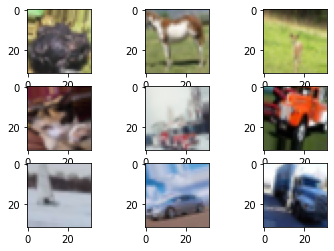

In [12]:
it = datagen_x_train.flow(X_train)
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.show()


<pre>

<font color='blue'>What is Dense layer</font>

DenseNet is composed of Dense blocks. In those blocks, the layers are densely connected together: Each layer receive in input all previous layers output feature maps.

see below diagram , all precceding layers are passing to next layer
<strong> Youtube video</strong> - <a id='section_id'>https://www.youtube.com/watch?v=oV4YBitzXKw</a>

Dense layer is split in to three parts 
1. <strong>DenseBlock </strong> -  A dense block is a group of layers connected to all their previous layers. A single layer looks like this:

    1. Batch Normalization
    2. ReLU activation
    3. 3x3 Convolution
The authors found that the pre-activation mode (BN and ReLU before the Conv) was more efficient than the usual post-activation mode.

<strong> Note </strong> that the authors recommend a zero padding before the convolution in order to have a fixed size.

2. <strong> Transistion </strong> -  used to concatenate to DenseNet, 
A transition layer is made of:

    1.Batch Normalization
    2.1x1 Convolution
    3.Average pooling

3. <strong> Growth Rate (L=12) </strong> - The growth rate regulates how much new information each layer contributes to the global state.

L=12 is enough for good performance, if want optimal perfromance use L=32, in this task we used L=12

due to this our parameter could reduced even for deep models

<strong>To summarize,</strong>
The DenseNet architecture uses the residual mechanism to its maximum by making every layer (of a same dense block) connect to their subsequent layers.

This model’s compactness makes the learned features non-redundant as they are all shared through a common knowledge.

<strong>Dropout require in DenseNet?</strong>
DenseNets also face overfitting problem if not severer. Existing dropout method can be applied but not as effective due to the introduced nonlinear connections. In particular, the property of feature-reuse in DenseNet will be impeded, and the dropout effect will be weakened by the spatial correlation inside feature maps.

Explored model with dropout rate 0.2 but still performance doesnt improve much for this task, from my understanding DenseNet 

Refer - <a id='section_id'>https://arthurdouillard.com/post/densenet/</a>
</pre>

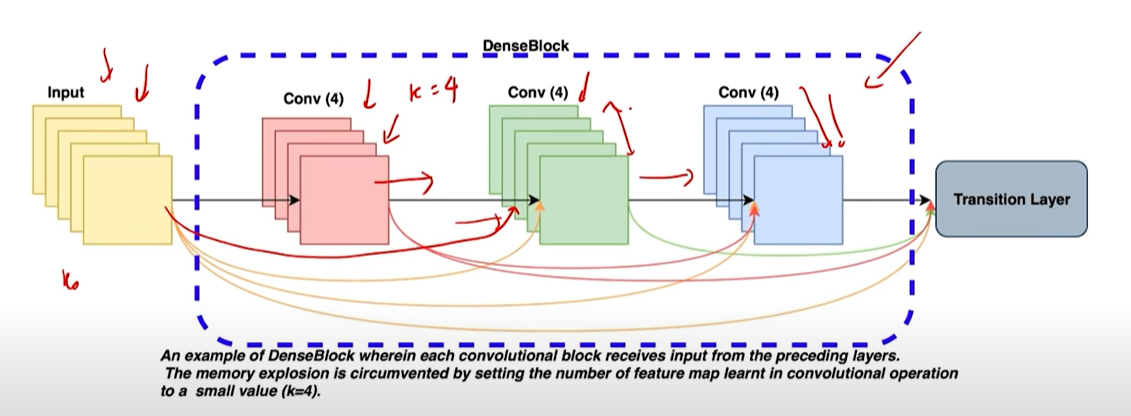

In [3]:
from IPython.display import Image
Image(filename=r"C:\Users\User\Desktop\Applied_A\Program\DEEP_Learning\Callback\Callbacks\Densenet_architecture.png")


In [13]:
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output

In [14]:

input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)

Last_Block = denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

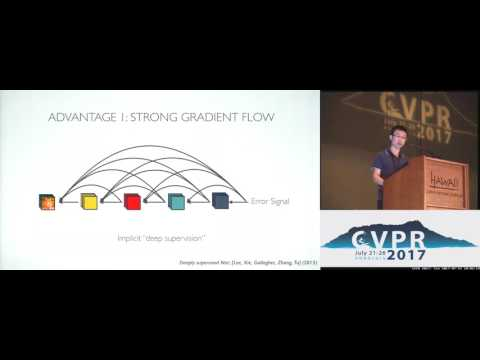

In [15]:
#https://arxiv.org/pdf/1608.06993.pdf
from IPython.display import IFrame, YouTubeVideo
YouTubeVideo(id='-W6y8xnd--U', width=600)

In [16]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 35)   945         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 35)   140         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 35)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [17]:
print(len(model.layers))

142


In [18]:
# Early Stopping - after val_accuracy reached 90
# refer - https://towardsdatascience.com/neural-network-with-tensorflow-how-to-stop-training-using-callback-5c8d575c18a9
ACCURACY_THRESHOLD = 0.90
class myCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}):
      
      if(logs.get('val_accuracy') > ACCURACY_THRESHOLD): 
        print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
        self.model.stop_training = True

early_stop = myCallback()

In [19]:
def decay_fn(epoch, lr):
    if epoch < 50:
        print('Learning rate 0.001')
        return 0.001
    elif epoch >= 50 and epoch < 75:
        print('Learning rate 0.0001')
        return 0.0001
    else:
        print('Learning rate 0.00001')
        return 0.00001

lr_scheduler = LearningRateScheduler(decay_fn)

In [20]:

csv_logger = CSVLogger('/gdrive/My Drive/CNN_CIFR/CSVlogs/trainings_new.log')


filepath="/gdrive/My Drive/CNN_CIFR/new_model_save_test/best_model-{epoch:02d}.h5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')

In [21]:
# determine Loss function and Optimizer
opt = keras.optimizers.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [22]:
(len(X_train) / batch_size)

781.25

In [23]:
model.fit(Data_aug_x_train,
          steps_per_epoch=(len(X_train) / batch_size),
                    epochs=100,
                    verbose=1, 
                    validation_data=(X_test, y_test),
          callbacks = [csv_logger, early_stop,checkpoint,lr_scheduler])

Learning rate 0.001
Epoch 1/100
782/781 [==============================] - ETA: 0s - loss: 1.5271 - accuracy: 0.4420
Epoch 00001: val_accuracy improved from -inf to 0.42130, saving model to /gdrive/My Drive/CNN_CIFR/new_model_save_test/best_model-01.h5
782/781 [==============================] - 158s 202ms/step - loss: 1.5271 - accuracy: 0.4420 - val_loss: 2.0455 - val_accuracy: 0.4213
Learning rate 0.001
Epoch 2/100
782/781 [==============================] - ETA: 0s - loss: 1.1444 - accuracy: 0.5874
Epoch 00002: val_accuracy improved from 0.42130 to 0.52880, saving model to /gdrive/My Drive/CNN_CIFR/new_model_save_test/best_model-02.h5
782/781 [==============================] - 155s 199ms/step - loss: 1.1444 - accuracy: 0.5874 - val_loss: 1.7069 - val_accuracy: 0.5288
Learning rate 0.001
Epoch 3/100
782/781 [==============================] - ETA: 0s - loss: 0.9802 - accuracy: 0.6532
Epoch 00003: val_accuracy improved from 0.52880 to 0.61630, saving model to /gdrive/My Drive/CNN_CIFR/ne

## CSV logger

In [1]:
import pandas as pd

train_log = pd.read_csv(r"C:\Users\User\Desktop\Applied_A\Assignment_All_in_one\DeepLearning\Dense_net_CIFAR\trainings_new.txt")

train_log

,epoch,accuracy,loss,val_accuracy,val_loss
0,0,0.44198,1.527068,0.4213,2.045505
1,1,0.58738,1.144373,0.5288,1.706873
2,2,0.65320,0.980196,0.6163,1.322578
3,3,0.69602,0.864334,0.6317,1.192576
4,4,0.72106,0.791180,0.6948,0.988763
5,5,0.74304,0.729754,0.6934,1.011601
6,6,0.76164,0.687559,0.6954,1.059975
7,7,0.77492,0.648694,0.7605,0.818448
8,8,0.78610,0.615635,0.7620,0.809635
9,9,0.79324,0.591438,0.7516,0.873774
